# ISOMAP (Isometric Feature Mapping)

- ISOMAP을 통해 차원을 축소 해 보자.
- ISOMAP은 Non-Linear한 Dimensionality Reduction 기법이다.
- Step 1, 2를 통해 Distance(D) Matrix를 만들고 Step 3에서 MDS를 사용해 Dimensionality를 Reduction한다.

- Step 1
  - Neighborhood Graph 구조를 만든다.
- Step 2
  - Shortest Path를 구해서 D를 만든다. (like Dijkstra, Floyd-Warshall, Bellman-Ford 등 사용 가능)
- Step 3
  - MDS를 수행하여 Embedding을 수행한다.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.spatial.distance import cdist
# from sklearn.utils.graph import single_source_shortest_path_length
from scipy.sparse.csgraph._shortest_path import shortest_path # Scikit-Learn 1.0부터는  sklearn.utils.graph_shortest_path를 지원하지 않아 scipy를 불러온다.
import scipy.io
from sklearn.decomposition import PCA

## Graph를 Plot 해 준다. (Image와 Point를 같이 표현)

In [2]:
def plot_graph(components, x, my_title="Facial Netowork Chart", filename="faces.png"):
    """
    오리지널과 변형된 후 Point를 찍어주고, 이미지를 Overlay한다. 그리고 Chart를 저장한다.

    Inputs
        components : 새롭게 차원이 축소되어 생성된 n * 2 matrix
        x - 오리지널 images (n x 4096개)
        filename - 저장될 파일 이름
        my_title - chart 이름

    Output
        Will save an image in directory "./img" with the provided filename
    """

    n, m = x.shape
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(111)
    ax.set_title(my_title)
    ax.set_xlabel('Component: 1')
    ax.set_ylabel('Component: 2')

    # Show 40 of the images ont the plot
    x_size = (max(components[:, 0]) - min(components[:, 0])) * 0.08
    y_size = (max(components[:, 1]) - min(components[:, 1])) * 0.08

    for i in range(20):
        img_num = np.random.randint(0, m)
        x0 = components[img_num, 0] - (x_size / 2.)
        y0 = components[img_num, 1] - (y_size / 2.)
        x1 = components[img_num, 0] + (x_size / 2.)
        y1 = components[img_num, 1] + (y_size / 2.)
        img = x[:, img_num].reshape(64, 64).T
        ax.imshow(img, aspect='auto', cmap=plt.cm.gray, interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1))

    # Show 2D components plot
    ax.scatter(components[:, 0], components[:, 1], marker='.',alpha=0.7)

    ax.set_ylabel('Up-Down Pose')
    ax.set_xlabel('Right-Left Pose')

    plt.savefig('img/'+filename)

    return None

## Step 1&2. Adjancency(Distance D Matrix)를 만든다.

### Step 1
- epsilon-Isomap을 수행하여, eps보다 작은 dist만을 adjacency matrix를 구해서 neighbor를 구한다.
- 그 외에 k-Isomap을 사용하면 k-nearest neighbor 함수를 사용할 수 있다.

### Step 2
 - Shortest Path알고리즘을 사용해 D Matrix를 만든다.

In [3]:
# 1. Step 1&2 - epsilon-Neighborhood를 찾고 shortest-path 알고리즘으로 Distance Matrix를 만듬 
def make_adjacency(data, dist_func="euclidean", eps=1):
   """
   ISOMAP을 위한 epsilon-Neighborhood를 찾고 shortest-path 알고리즘으로 Distance Matrix를 만듬 
   Weighted Adjacency Matirx를 각 Point별로 찾는다. eps(epsiolon)안에 들어온 것들만 Neighbor로 취급한다. 

   Neighbor끼리의 거리 계산은 기본은 euclidean이지만, 아래와 같은 distance metric을 cdist가 지원한다.
    'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation',
    'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'jensenshannon',
    'kulczynski1', 'mahalanobis', 'matching', 'minkowski',
    'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener',
    'sokalsneath', 'sqeuclidean', 'yule'.

    INPUT
      data - (ndarray) the dataset which should be a numpy array
      dist_func - (str) the distance metric to use. See SciPy cdist for list of
                  options
      eps - (int/float) epsilon value to define the local region. I.e. two points
                        are connected if they are within epsilon of each other.

    OUTPUT
      short - (ndarray) Distance matrix, the shortest path from every point to
          every other point in the set, INF if not reachable. 
   """
   n, m = data.shape
   dist = cdist(data.T, data.T, metric=dist_func)
   adj =  np.zeros((m, m)) + np.inf
   bln = dist < eps
   adj[bln] = dist[bln]
   short = shortest_path(adj)

   return short


# Step 3. MDS
- MDS 알고리즘을 사용하여 만들어진 Distance Matrix를 사용해 Dimeisionality Reduction을 수행한다.

In [4]:
# Step 3. MDS 알고리즘을 사용하여, 원본 dimension을 변환한다.
def MDS(d, dim, m):
    h = np.eye(m) - (1/m)*np.ones((m, m))
    d = d**2
    c = -1/(2*m) * h.dot(d).dot(h)
    evals, evecs = linalg.eig(c)
    idx = evals.argsort()[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]
    evals = evals[:dim] 
    evecs = evecs[:, :dim]
    z = evecs.dot(np.diag(evals**(-1/2)))
    return z

# Main ISOMAP Function

In [5]:
def isomap(d, dim=2):
    """
    Adjacency Matrix를 받아서 MDS를 통해 ISOMAP을 계산한다.

    INPUT
      d - Adjacency Distance matrix between nodes. 
      dim - 감소 시키고 싶은 dimension의 수 
    
    OUTPUT
      z - 감소된 공간으로 Projected된 Data 
    """

    n, m = d.shape
    z = MDS(d, dim, m)

    return z.real


# Main Function
- 얼굴 동상 이미지를 읽어 오고, Step 1~3까지를 수행하여 Dimensionality Reduction을 수행한다.

In [6]:

mat = scipy.io.loadmat('data/isomap.mat')
m=mat['images']
print("ISOMAP")

# D = make_adjacency(m, eps=386, dist_func="cityblock")
D = make_adjacency(m, eps=386, dist_func="euclidean")
z = isomap(D)


ISOMAP


# Plot
- ISOMAP과 PCA 각각으로 Reduction하였을 때의 Data Point의 2차원 Projection Plot과 함께 해당 Image를 Plotting해 준다.
- ISOMAP과 PCA를 비교한다.

ISOMAP
PCA


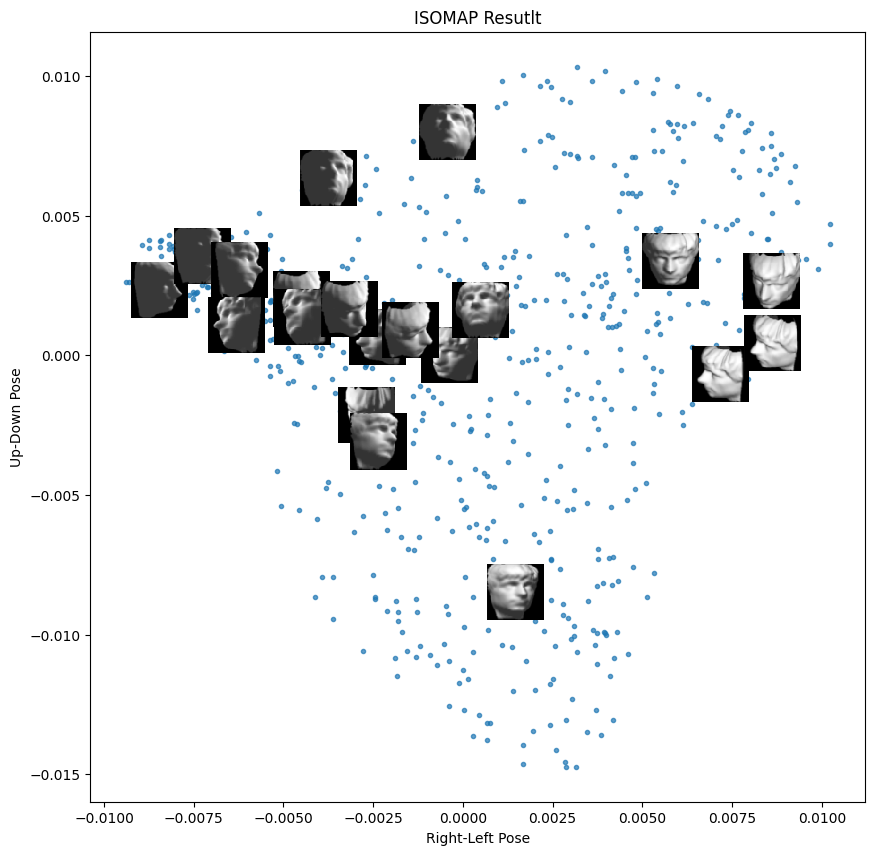

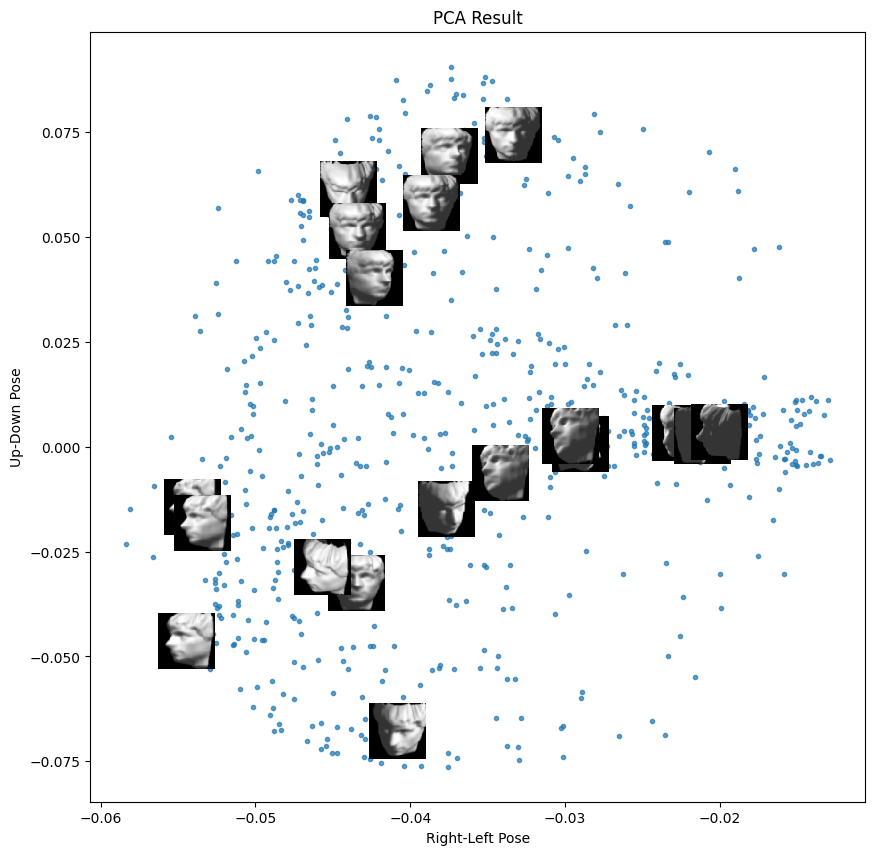

In [8]:
print("ISOMAP")
plot_graph(z, x=m, my_title="ISOMAP Resutlt")
pca = PCA(n_components=2)
z = pca.fit(m)

print("PCA")
plot_graph(z.components_.T, x=m, my_title="PCA Result", 
        filename="pca_faces.png")